# TD 3 | Computational Statistics | MVA 23-24
### Meilame TAYEBJEE

In [50]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats
from numba import jit
import seaborn as sns
from scipy import stats
from tqdm import tqdm

## Exercise 1: Hasting-Metropolis within Gibbs – Stochastic Approximation EM

### Data generation

In [2]:
#-----INPUTS-----#
p0 = 1

sigma_t0 = 0.1
sigma_v0 = 0.1

s_t0 = 0.1
s_v0 = 0.1

t0_bar_bar = 1
v0_bar_bar = 1

m = 8
m_ksi = m
m_tau = m

v = 1.9
v_ksi = v
v_tau = v

N = 100
k = 21


In [3]:
#Data generation
def generateData(p0 = p0,sigma_t0 = sigma_t0, sigma_v0 = sigma_v0, s_t0 = s_t0, s_v0 = s_v0, t0_bar_bar = t0_bar_bar, v0_bar_bar = v0_bar_bar, m = m, m_lsi = m_ksi, m_tau = m_tau, v = v, v_ksi= v_ksi, v_tau = v_tau, N = N, k = k):

    t0_bar = np.random.normal(t0_bar_bar, sigma_t0, 1)
    v0_bar = np.random.normal(v0_bar_bar, sigma_v0, 1)


    sigma_ksi_sq = stats.invwishart.rvs(m_ksi, v_ksi)
    sigma_tau_sq = stats.invwishart.rvs(m_tau, v_tau)
    sigma_sq = stats.invwishart.rvs(m, v)

    t0 = np.random.normal(t0_bar, sigma_t0, 1)
    v0 = np.random.normal(v0_bar, sigma_v0, 1)

    epsilon = np.random.normal(0, np.sqrt(sigma_sq), (N, k))
    ksi = np.random.normal(0, np.sqrt(sigma_ksi_sq), (N,1))
    alpha = np.exp(ksi)

    tau = np.random.normal(0, np.sqrt(sigma_tau_sq), (N,1))


    y = np.zeros((N,k))
    for t in range(k):
        y[:, t] = p0 + (v0*alpha*(t-t0-tau)).reshape((N,)) + epsilon[:,t]

    return y,alpha, tau, t0, v0, t0_bar, v0_bar, sigma_ksi_sq, sigma_tau_sq, sigma_sq, epsilon

y, true_alpha, true_tau, true_t0, true_v0, true_t0_bar, true_v0_bar, true_sigma_ksi_sq, true_sigma_tau_sq, true_sigma_sq, noise = generateData()
true_ksi = np.log(true_alpha)

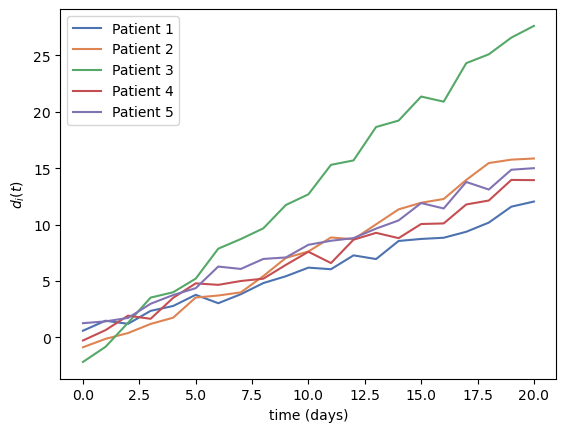

In [16]:
for i in range(1,6):
    plt.plot(y[i], label=f'Patient {i}')
    
plt.xlabel("time (days)")
plt.ylabel("$d_i(t)$")
plt.legend()
plt.show()

### HM-SAEM

#### Hastings-Metropolis Sampler

In [5]:
true_z = np.zeros(2*N+2)
true_z[0] = true_t0
true_z[1] = true_v0
true_z[2:N+2] = true_ksi.reshape((N,))
true_z[N+2:] = true_tau.reshape((N,))


In [6]:
def yResidual(y, t0, v0, ksi, tau, p0 = p0):
    res = np.zeros((N,k))
    for t in range(k):
        res[:, t] = y[:, t] - (p0 + (v0*np.exp(ksi)*(t-t0-tau)).reshape((N,)))
    return res

In [14]:
@jit(nopython=True)
def logTargetPosteriorZ(y, z, t0_bar, v0_bar, sigma_ksi_sq, sigma_tau_sq, sigma_sq):
    t0 = z[0]
    v0 = z[1]
    ksi = z[2:N+2]
    tau = z[N+2:]

    yResidual = np.zeros((N,k))
    for t in range(k):
        yResidual[:, t] = y[:, t] - (p0 + (v0*np.exp(ksi)*(t-t0-tau)).reshape((N,)))
    
    res = np.sum(np.square(yResidual)) / (2*sigma_sq)

    res = res + np.sum(ksi)
    res = res + np.sum(np.square(np.exp(ksi))) / (2*sigma_ksi_sq)
    res = res + np.sum(np.square(tau)) / (2*sigma_tau_sq)
    res = res + np.square(t0) / (2*sigma_t0**2)
    res = res - t0*t0_bar / (sigma_t0**2)
    res = res + np.square(v0 - v0_bar) / (2*sigma_v0**2)
    res = res - v0*v0_bar / (sigma_v0**2) 
    return -res


def metropolisHastingSampler(y, z_init, t0_bar, v0_bar, sigma_ksi_sq, sigma_tau_sq, sigma_sq, sigma_sq_prop, maxIter = 10000):

    count = 0
    z_current = z_init

    for k in range(maxIter):
        zstar = np.random.randn(z_current.shape[0])*np.sqrt(sigma_sq_prop) + z_current

        #Acceptance probability
        logTargetProposition = logTargetPosteriorZ(y, zstar, t0_bar, v0_bar, sigma_ksi_sq, sigma_tau_sq, sigma_sq)
        logTargetCurrent =  logTargetPosteriorZ(y, z_current, t0_bar, v0_bar, sigma_ksi_sq, sigma_tau_sq, sigma_sq)
        logRatio = logTargetProposition - logTargetCurrent

        probAcceptance = min(1, np.exp(min(0, logRatio)))


        #Toss the coin !
        u = np.random.rand()
        if u < probAcceptance:
            z_current = zstar
            count += 1
    
    return z_current, count/maxIter

z_init = true_z + np.random.randn(true_z.shape[0])*0.05

z_pred, accRate = metropolisHastingSampler(y, z_init, true_t0_bar, true_v0_bar, true_sigma_ksi_sq, true_sigma_tau_sq, true_sigma_sq, 5*1e-5, maxIter = 100)

print("Acceptance Rate ", accRate)
print("True t0: ", true_t0)
print("True v0: ", true_v0)

print("Predicted t0: ", z_pred[0])
print("Predicted v0: ", z_pred[1])


Acceptance Rate  0.19
True t0:  [1.12392887]
True v0:  [1.07060068]
Predicted t0:  1.1096976428793317
Predicted v0:  1.078793432734481


#### SAEM

In [8]:
print("True t0_bar : ", true_t0_bar)
print("True v0_bar : ", true_v0_bar)
print("True sigma_ksi_sq : ", true_sigma_ksi_sq)
print("True sigma_tau_sq : ", true_sigma_tau_sq)
print("True sigma_sq : ", true_sigma_sq)

def SAEM(y, t0_bar_init, v0_bar_init, sigma_ksi_sq_init, sigma_tau_sq_init, sigma_sq_init, sigma_sq_prop = 3*1e-6, burn_in = 2, alphaBurnIn = 0.7, maxIter = 100, verbose= False):

    t0_bar = t0_bar_init
    v0_bar = v0_bar_init
    sigma_ksi_sq = sigma_ksi_sq_init
    sigma_tau_sq = sigma_tau_sq_init
    sigma_sq = sigma_sq_init

    all_t0_bar = [t0_bar_init]
    all_v0_bar = [v0_bar_init]
    all_sigma_ksi_sq = [sigma_ksi_sq_init]
    all_sigma_tau_sq = [sigma_tau_sq_init]
    all_sigma_sq = [sigma_sq_init]

    #----INIT----#
    z_init = true_z
    S = np.zeros((5,1))
    t0_init = z_init[0]
    v0_init = z_init[1]
    ksi_init = z_init[2:N+2]
    tau_init = z_init[N+2:]

    yResiduals_init = yResidual(y, t0_init, v0_init, ksi_init, tau_init)
    S[0] = t0_init
    S[1] = v0_init
    S[2] = np.sum(np.square(ksi_init))
    S[3] = np.sum(np.square(tau_init))
    S[4] = np.sum(np.square(yResiduals_init)) / (2*sigma_sq)
    #-------
    
    z = z_init
    #Step sizes
    epsilons = np.ones((maxIter,))
    epsilons[burn_in+1:] = np.array([(k - burn_in)**(- alphaBurnIn) for k in range(burn_in+1, maxIter)])
    avgAcceptanceRate = 0
    for l in range(maxIter):
        if verbose:
            print("Iteration : ", l)
        #Simulation
        z, accRate = metropolisHastingSampler(y, z, t0_bar, v0_bar, sigma_ksi_sq, sigma_tau_sq, sigma_sq, sigma_sq_prop, maxIter = 100)
        avgAcceptanceRate += accRate 
        t0 = z[0]
        v0 = z[1]
        ksi = z[2:N+2]
        tau = z[N+2:]

        yResiduals = yResidual(y, t0, v0, ksi, tau)

        if verbose:
            print("Acceptance rate in MH : ", accRate)
        #Stochastic approximation
        S[0] = S[0] + epsilons[l] * (t0- S[0])
        S[1] = S[1] + epsilons[l] * (v0- S[1])
        S[2] = S[2] + epsilons[l] * (np.sum(np.square(ksi))- S[2])
        S[3] = S[3] + epsilons[l] * ( np.sum(np.square(tau))- S[3])
        S[4] = S[4] + epsilons[l] * ( (np.sum(np.square(yResiduals)) / (2*sigma_sq))- S[4])

        #Maximization
        t0_bar = ((s_t0**2) *S[0] + (sigma_t0**2) * t0_bar_bar) / (s_t0**2 + sigma_t0**2)
        v0_bar = ((s_v0**2) *S[1] + (sigma_v0**2) * v0_bar_bar) / (s_v0**2 + sigma_v0**2)
        sigma_ksi_sq = (v_ksi**2 + S[2]) / (m_ksi + N + 2)
        sigma_tau_sq = (v_tau**2 + S[3]) / (m_tau + N + 2)
        sigma_sq = (v**2 + S[4]) / (m + N*k + 2)

        all_t0_bar.append(float(t0_bar))
        all_v0_bar.append(float(v0_bar))
        all_sigma_ksi_sq.append(float(sigma_ksi_sq))
        all_sigma_tau_sq.append(float(sigma_tau_sq))
        all_sigma_sq.append(float(sigma_sq))

    avgAcceptanceRate = round(avgAcceptanceRate / maxIter, 2)
    print("Average acceptance rate in the HM runs : ", avgAcceptanceRate)
    return t0_bar, v0_bar, sigma_ksi_sq, sigma_tau_sq, sigma_sq, all_t0_bar, all_v0_bar, all_sigma_ksi_sq, all_sigma_tau_sq, all_sigma_sq


t0_bar_init = 0
v0_bar_init = 2
sigma_ksi_sq_init = 1
sigma_tau_sq_init = 1
sigma_sq_init = 0.5

t0_bar, v0_bar, sigma_ksi_sq, sigma_tau_sq, sigma_sq, all_t0_bar, all_v0_bar, all_sigma_ksi_sq, all_sigma_tau_sq, all_sigma_sq = SAEM(y, t0_bar_init, v0_bar_init, sigma_ksi_sq_init, sigma_tau_sq_init, sigma_sq_init, verbose = False)

print("Estimated t0_bar : ", t0_bar)
print("Estimated v0_bar : ", v0_bar)
print("Estimated sigma_ksi_sq : ", sigma_ksi_sq)
print("Estimated sigma_tau_sq : ", sigma_tau_sq)
print("Estimated sigma_sq : ", sigma_sq)


True t0_bar :  [0.97208316]
True v0_bar :  [1.07670037]
True sigma_ksi_sq :  0.31314056476002866
True sigma_tau_sq :  0.3401751143046741
True sigma_sq :  0.3302857530121575
Average acceptance rate in the HM runs :  0.26
Estimated t0_bar :  [1.0574465]
Estimated v0_bar :  [1.05030094]
Estimated sigma_ksi_sq :  [0.24726876]
Estimated sigma_tau_sq :  [0.3361606]
Estimated sigma_sq :  [0.40479856]


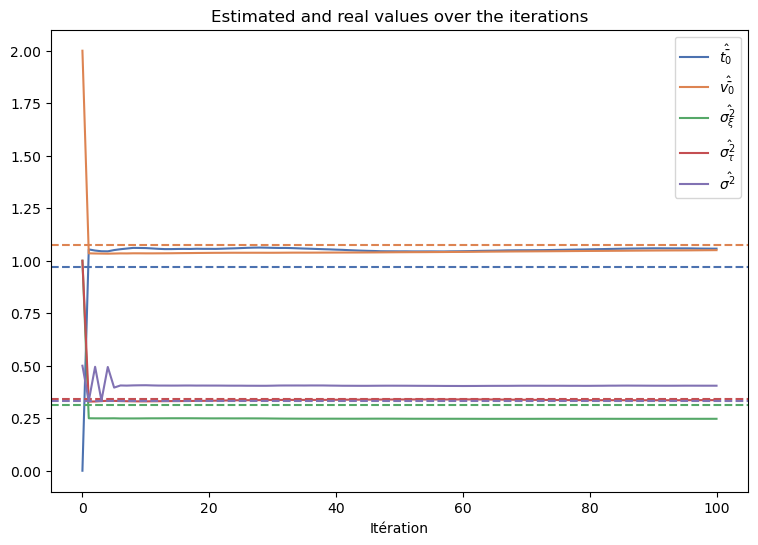

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns  # Importation de seaborn pour utiliser ses palettes de couleurs

sns.set_palette("deep")
colors = sns.color_palette("deep")

plt.figure(figsize=(9, 6))

plt.plot(all_t0_bar, label=r"$\hat{\bar{t_0}}$", color=colors[0])
plt.axhline(y=true_t0_bar, linestyle='--', color=colors[0])

plt.plot(all_v0_bar, label=r"$\hat{\bar{v_0}}$", color=colors[1])
plt.axhline(y=true_v0_bar, linestyle='--',  color=colors[1])

plt.plot(all_sigma_ksi_sq, label=r"$\hat{\sigma_{\xi}^2}$", color=colors[2])
plt.axhline(y=true_sigma_ksi_sq, linestyle='--',  color=colors[2])

plt.plot(all_sigma_tau_sq, label=r"$\hat{\sigma_{\tau}^2}$", color=colors[3])
plt.axhline(y=true_sigma_tau_sq, linestyle='--', color=colors[3])

plt.plot(all_sigma_sq, label=r"$\hat{\sigma^2}$", color=colors[4])
plt.axhline(y=true_sigma_sq, linestyle='--', color=colors[4])

plt.legend()
plt.xlabel("Itération")
plt.title("Estimated and real values over the iterations")

plt.show()





### HMwG-SAEM : individual and Block version

#### Updated Likelihoods

In [10]:
@jit(nopython=True)
def logTargetPosteriorZi(idx, y, z,sigma_ksi_sq, sigma_tau_sq, sigma_sq):
    t0 = z[0]
    v0 = z[1]
    ksi = z[2:N+2].reshape((N,))
    tau = z[N+2:].reshape((N,))

    yResidual = np.zeros((k, ))
    for t in range(k):
        yResidual[t] = y[idx, t] - (p0 + (v0*np.exp(ksi[idx])*(t-t0-tau[idx])))
    
    res = np.sum(np.square(yResidual)) / (2*sigma_sq)
    res = res + ksi[idx]
    res = res + np.square(np.exp(ksi[idx])) / (2*sigma_ksi_sq)
    res = res + np.square(tau[idx]) / (2*sigma_tau_sq)
    return -res



@jit(nopython=True)
def logTargetPosteriorZiBlock(y, z,sigma_ksi_sq, sigma_tau_sq, sigma_sq):
    t0 = z[0]
    v0 = z[1]
    ksi = z[2:N+2]
    tau = z[N+2:]

    yResidual = np.zeros((N,k))
    for t in range(k):
        yResidual[:, t] = y[:, t] - (p0 + (v0*np.exp(ksi)*(t-t0-tau)).reshape((N,)))
    
    res = np.sum(np.square(yResidual)) / (2*sigma_sq)

    res = res + np.sum(ksi)
    res = res + np.sum(np.square(np.exp(ksi))) / (2*sigma_ksi_sq)
    res = res + np.sum(np.square(tau)) / (2*sigma_tau_sq)
    return -res

@jit(nopython=True)
def logTargetPosteriorZpop(y, z, t0_bar, v0_bar, sigma_sq):
    t0 = z[0]
    v0 = z[1]
    ksi = z[2:N+2]
    tau = z[N+2:]

    yResidual = np.zeros((N,k))
    for t in range(k):
        yResidual[:, t] = y[:, t] - (p0 + (v0*np.exp(ksi)*(t-t0-tau)).reshape((N,)))

    res = np.sum(np.square(yResidual)) / (2*sigma_sq)
    res = res + np.square(t0) / (2*sigma_t0**2)
    res = res - t0*t0_bar / (sigma_t0**2)
    res = res + np.square(v0 - v0_bar) / (2*sigma_v0**2)
    res = res - v0*v0_bar / (sigma_v0**2) 
    return -res

#### Updated Hasting-Metropolis Algorithms

In [11]:
def HMforZi(idx, y, z_init, sigma_ksi_sq, sigma_tau_sq, sigma_sq, sigma_sq_prop = 3*1e-3, maxIter = 100):

    count = 0
    zpop_given = z_init[0:2] #This will not move !
    zidx_current = [z_init[idx + 2], z_init[N+2+idx]] # ksi_idx and tau_idx
    z_current = z_init #Over the course of the algorithm, it is always all the z_init, with only the index idx +2 and idx+N+2 that changes

    for k in range(maxIter):
        zidx_prop = np.random.randn(2)*np.sqrt(sigma_sq_prop) + zidx_current
        z_prop = z_current.copy()
        z_prop[idx+2] = zidx_prop[0]
        z_prop[N+2+idx] = zidx_prop[1]
        #Acceptance probability
        logTargetProposition = logTargetPosteriorZi(idx, y, z_prop, sigma_ksi_sq, sigma_tau_sq, sigma_sq)
        logTargetCurrent =  logTargetPosteriorZi(idx, y, z_current, sigma_ksi_sq, sigma_tau_sq, sigma_sq)
        logRatio = logTargetProposition - logTargetCurrent

        probAcceptance = min(1, np.exp(min(0, logRatio)))


        #Toss the coin !
        u = np.random.rand()
        if u < probAcceptance:
            z_current = z_prop
            zidx_current = zidx_prop
            count += 1
    
    return z_current, count/maxIter


def HMforZiBlock(y, z_init, sigma_ksi_sq, sigma_tau_sq, sigma_sq, sigma_sq_prop = 3*1e-3, maxIter = 100):

    count = 0
    zpop_given = z_init[0:2] #This will not move !
    zi_current = z_init[2:]
    z_current = z_init #Over the course of the algorithm, it is always [zpop_given, zi_current]

    for k in range(maxIter):
        zi_prop = np.random.randn(zi_current.shape[0])*np.sqrt(sigma_sq_prop) + zi_current
        z_prop = np.concatenate((zpop_given, zi_prop))
        #Acceptance probability
        logTargetProposition = logTargetPosteriorZiBlock(y, z_prop, sigma_ksi_sq, sigma_tau_sq, sigma_sq)
        logTargetCurrent =  logTargetPosteriorZiBlock(y, z_current, sigma_ksi_sq, sigma_tau_sq, sigma_sq)
        logRatio = logTargetProposition - logTargetCurrent

        probAcceptance = min(1, np.exp(min(0, logRatio)))


        #Toss the coin !
        u = np.random.rand()
        if u < probAcceptance:
            zi_current = zi_prop
            z_current = z_prop
            count += 1
    
    return z_current, count/maxIter


def HMforZpop(y, z_init, t0_bar, v0_bar, sigma_sq, sigma_sq_prop = 5*1e-5, maxIter = 100):

    count = 0
    zi_given = z_init[2:] #This will not move !
    zpop_current = z_init[0:2]
    z_current = z_init #Over the course of the algorithm, it is always [zpop_current, zi_given]

    for k in range(maxIter):
        zpop_prop = np.random.randn(zpop_current.shape[0])*np.sqrt(sigma_sq_prop) + zpop_current
        z_prop = np.concatenate((zpop_prop, zi_given))
        #Acceptance probability
        logTargetProposition = logTargetPosteriorZpop(y, z_prop, t0_bar, v0_bar, sigma_sq)
        logTargetCurrent =  logTargetPosteriorZpop(y, z_current, t0_bar, v0_bar, sigma_sq)
        logRatio = logTargetProposition - logTargetCurrent
        probAcceptance = min(1, np.exp(min(0, logRatio)))


        #Toss the coin !
        u = np.random.rand()
        if u < probAcceptance:
            zpop_current = zpop_prop
            z_current = z_prop
            count += 1
    
    return z_current, count/maxIter


#----------TESTS----------#
idx = np.random.randint(0, N)
print("Testing HM for Zi i = {} (for example)".format(idx))

z_init = true_z.copy()
noise = 0.01
z_init[idx+2] += noise*np.random.randn()
z_init[N+2+idx] += noise*np.random.randn()
z_pred, accRate = HMforZi(5, y, z_init, sigma_ksi_sq, sigma_tau_sq, sigma_sq)

print("Acceptance Rate : ", accRate)
print("True ksi_{}: ".format(idx), true_ksi[idx])
print("True tau_{}: ".format(idx), true_tau[idx])
print("Predicted ksi_{}: ".format(idx), z_pred[idx+2])
print("Predicted tau_{}: ".format(idx), z_pred[N+2+idx])

print("----------------")
z_pred, accRate = HMforZiBlock(y, true_z + np.concatenate(([1,1], 0.05*np.random.randn(2*N))), sigma_ksi_sq, sigma_tau_sq, sigma_sq)
print("Testing HM for Block (Zi)_i")
print("Acceptance Rate : ", accRate)

ksi_pred = z_pred[2:N+2]
tau_pred = z_pred[N+2:]
print("RMSE between true and predicted xi : ", np.linalg.norm(true_ksi.reshape((N,)) - ksi_pred)/N)
print("RMSE between true and predicted tau : ", np.linalg.norm(true_tau.reshape((N,)) - tau_pred)/N)

print("----------------")
print("Testing HM for Zpop")

z_pred, accRate = HMforZpop(y, true_z + np.concatenate((0.05*np.random.randn(2), np.zeros((2*N)))), true_t0_bar, true_v0_bar, true_sigma_sq)
print("Acceptance Rate : ", accRate)
print("True t0: ", true_t0)
print("True v0: ", true_v0)

print("Predicted t0: ", z_pred[0])
print("Predicted v0: ", z_pred[1])


Testing HM for Zi i = 31 (for example)
Acceptance Rate :  0.37
True ksi_31:  [0.82751094]
True tau_31:  [-0.86249627]
Predicted ksi_31:  0.8146778251140638
Predicted tau_31:  -0.8666222563191209
----------------
Testing HM for Block (Zi)_i
Acceptance Rate :  0.22
RMSE between true and predicted xi :  0.02907686803081822
RMSE between true and predicted tau :  0.024425733152705065
----------------
Testing HM for Zpop
Acceptance Rate :  0.18
True t0:  [1.12392887]
True v0:  [1.07060068]
Predicted t0:  1.0865488902412463
Predicted v0:  1.0673142679008796


#### Classic (individual) HMwG-SAEM

True t0_bar :  [0.97208316]
True v0_bar :  [1.07670037]
True sigma_ksi_sq :  0.31314056476002866
True sigma_tau_sq :  0.3401751143046741
True sigma_sq :  0.3302857530121575
Average acceptance rate in the Zi HMwG runs :  0.27
Average acceptance rate in the Zpop HMwG runs :  0.23
Estimated t0_bar :  [1.08899667]
Estimated v0_bar :  [1.06979092]
Estimated sigma_ksi_sq :  [0.25286861]
Estimated sigma_tau_sq :  [0.38187714]
Estimated sigma_sq :  [0.40778368]


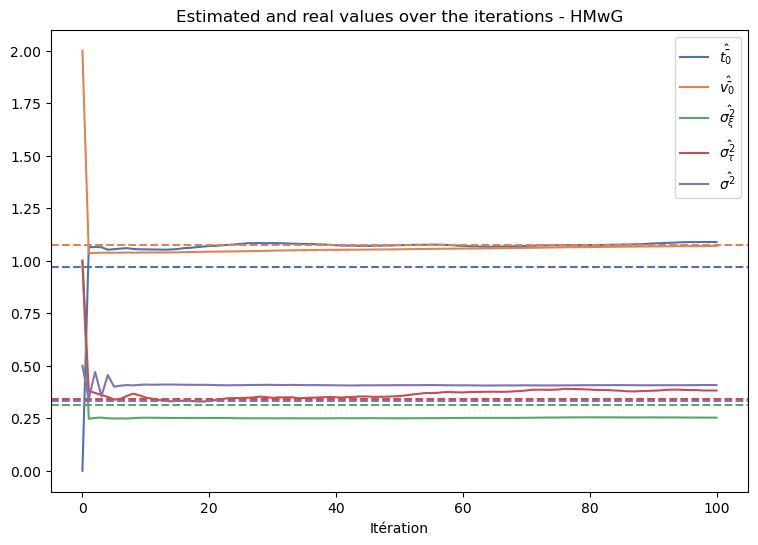

In [12]:
def HMwG_SAEM(y, t0_bar_init, v0_bar_init, sigma_ksi_sq_init, sigma_tau_sq_init, sigma_sq_init, sigma_sq_propZi = 3*1e-3, sigma_sq_propZpop = 3*1e-5, burn_in = 2, alphaBurnIn = 0.7, maxIter = 100, verbose= False):
    
    t0_bar = t0_bar_init
    v0_bar = v0_bar_init
    sigma_ksi_sq = sigma_ksi_sq_init
    sigma_tau_sq = sigma_tau_sq_init
    sigma_sq = sigma_sq_init

    all_t0_bar = [t0_bar_init]
    all_v0_bar = [v0_bar_init]
    all_sigma_ksi_sq = [sigma_ksi_sq_init]
    all_sigma_tau_sq = [sigma_tau_sq_init]
    all_sigma_sq = [sigma_sq_init]

    #----INIT----#
    z_init = true_z
    S = np.zeros((5,1))
    t0_init = z_init[0]
    v0_init = z_init[1]
    ksi_init = z_init[2:N+2]
    tau_init = z_init[N+2:]

    yResiduals_init = yResidual(y, t0_init, v0_init, ksi_init, tau_init)
    S[0] = t0_init
    S[1] = v0_init
    S[2] = np.sum(np.square(ksi_init))
    S[3] = np.sum(np.square(tau_init))
    S[4] = np.sum(np.square(yResiduals_init)) / (2*sigma_sq)
    #-------
    
    z = z_init.reshape((2*N+2,))
    #Step sizes
    epsilons = np.ones((maxIter,))
    epsilons[burn_in+1:] = np.array([(k - burn_in)**(- alphaBurnIn) for k in range(burn_in+1, maxIter)])

    avgAcceptanceRateZi = np.zeros((N,))
    avgAcceptanceRateZpop = 0
    for l in range(maxIter):
        if verbose:
            print("Iteration : ", l)
        #Simulation
        for idx in range(N):
            z, accRateZi = HMforZi(idx, y, z, sigma_ksi_sq, sigma_tau_sq, sigma_sq, sigma_sq_propZi, maxIter = 100)
            avgAcceptanceRateZi[idx] += accRateZi
        z, accRateZpop = HMforZpop(y, z, t0_bar, v0_bar, sigma_sq, sigma_sq_propZpop, maxIter = 100)
        avgAcceptanceRateZpop += accRateZpop
        
        t0 = z[0]
        v0 = z[1]
        ksi = z[2:N+2]
        tau = z[N+2:]

        yResiduals = yResidual(y, t0, v0, ksi, tau)

        if verbose:
            print("Acceptance rate in MH : ", accRate)
        #Stochastic approximation
        S[0] = S[0] + epsilons[l] * (t0- S[0])
        S[1] = S[1] + epsilons[l] * (v0- S[1])
        S[2] = S[2] + epsilons[l] * (np.sum(np.square(ksi))- S[2])
        S[3] = S[3] + epsilons[l] * ( np.sum(np.square(tau))- S[3])
        S[4] = S[4] + epsilons[l] * ( (np.sum(np.square(yResiduals)) / (2*sigma_sq))- S[4])

        #Maximization
        t0_bar = ((s_t0**2) *S[0] + (sigma_t0**2) * t0_bar_bar) / (s_t0**2 + sigma_t0**2)
        v0_bar = ((s_v0**2) *S[1] + (sigma_v0**2) * v0_bar_bar) / (s_v0**2 + sigma_v0**2)
        sigma_ksi_sq = (v_ksi**2 + S[2]) / (m_ksi + N + 2)
        sigma_tau_sq = (v_tau**2 + S[3]) / (m_tau + N + 2)
        sigma_sq = (v**2 + S[4]) / (m + N*k + 2)

        all_t0_bar.append(float(t0_bar))
        all_v0_bar.append(float(v0_bar))
        all_sigma_ksi_sq.append(float(sigma_ksi_sq))
        all_sigma_tau_sq.append(float(sigma_tau_sq))
        all_sigma_sq.append(float(sigma_sq))

    avgAcceptanceRateZi = round(np.mean(avgAcceptanceRateZi) / maxIter, 2)
    avgAcceptanceRateZpop = round(avgAcceptanceRateZpop / maxIter, 2)
    print("Average acceptance rate in the Zi HMwG runs : ", avgAcceptanceRateZi)
    print("Average acceptance rate in the Zpop HMwG runs : ", avgAcceptanceRateZpop)
    return t0_bar, v0_bar, sigma_ksi_sq, sigma_tau_sq, sigma_sq, all_t0_bar, all_v0_bar, all_sigma_ksi_sq, all_sigma_tau_sq, all_sigma_sq


t0_bar_init = 0
v0_bar_init = 2
sigma_ksi_sq_init = 1
sigma_tau_sq_init = 1
sigma_sq_init = 0.5

print("True t0_bar : ", true_t0_bar)
print("True v0_bar : ", true_v0_bar)
print("True sigma_ksi_sq : ", true_sigma_ksi_sq)
print("True sigma_tau_sq : ", true_sigma_tau_sq)
print("True sigma_sq : ", true_sigma_sq)

t0_bar, v0_bar, sigma_ksi_sq, sigma_tau_sq, sigma_sq, all_t0_bar, all_v0_bar, all_sigma_ksi_sq, all_sigma_tau_sq, all_sigma_sq = HMwG_SAEM(y, t0_bar_init, v0_bar_init, sigma_ksi_sq_init, sigma_tau_sq_init, sigma_sq_init)

print("Estimated t0_bar : ", t0_bar)
print("Estimated v0_bar : ", v0_bar)
print("Estimated sigma_ksi_sq : ", sigma_ksi_sq)
print("Estimated sigma_tau_sq : ", sigma_tau_sq)
print("Estimated sigma_sq : ", sigma_sq)


sns.set_palette("deep")
colors = sns.color_palette("deep")

plt.figure(figsize=(9, 6))

plt.plot(all_t0_bar, label=r"$\hat{\bar{t_0}}$", color=colors[0])
plt.axhline(y=true_t0_bar, linestyle='--', color=colors[0])

plt.plot(all_v0_bar, label=r"$\hat{\bar{v_0}}$", color=colors[1])
plt.axhline(y=true_v0_bar, linestyle='--',  color=colors[1])

plt.plot(all_sigma_ksi_sq, label=r"$\hat{\sigma_{\xi}^2}$", color=colors[2])
plt.axhline(y=true_sigma_ksi_sq, linestyle='--',  color=colors[2])

plt.plot(all_sigma_tau_sq, label=r"$\hat{\sigma_{\tau}^2}$", color=colors[3])
plt.axhline(y=true_sigma_tau_sq, linestyle='--', color=colors[3])

plt.plot(all_sigma_sq, label=r"$\hat{\sigma^2}$", color=colors[4])
plt.axhline(y=true_sigma_sq, linestyle='--', color=colors[4])

plt.legend()
plt.xlabel("Itération")
plt.title("Estimated and real values over the iterations - HMwG")

plt.show()


#### BlockHMwG-SAEM

True t0_bar :  [0.97208316]
True v0_bar :  [1.07670037]
True sigma_ksi_sq :  0.31314056476002866
True sigma_tau_sq :  0.3401751143046741
True sigma_sq :  0.3302857530121575
Average acceptance rate in the Zi HMwG runs :  0.24
Average acceptance rate in the Zpop HMwG runs :  0.23
Estimated t0_bar :  [1.04129738]
Estimated v0_bar :  [1.05282499]
Estimated sigma_ksi_sq :  [0.24956744]
Estimated sigma_tau_sq :  [0.32471197]
Estimated sigma_sq :  [0.40571832]


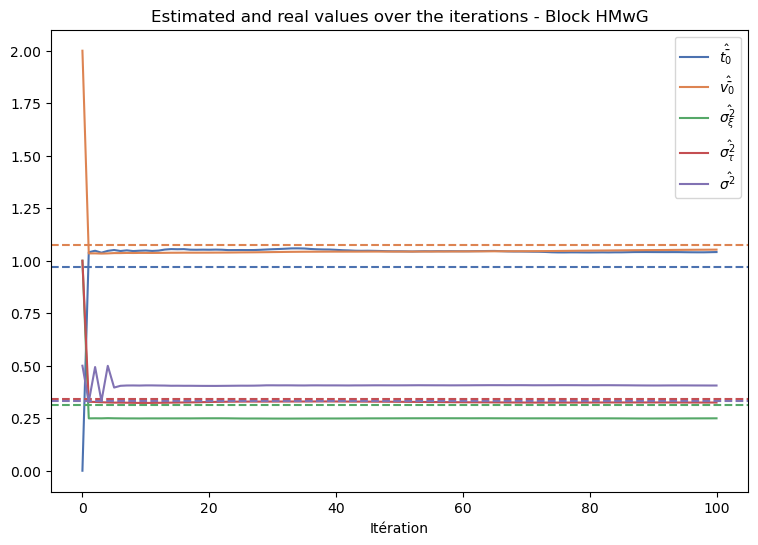

In [13]:
def BlockHMwG_SAEM(y, t0_bar_init, v0_bar_init, sigma_ksi_sq_init, sigma_tau_sq_init, sigma_sq_init, sigma_sq_propZi = 5*1e-6, sigma_sq_propZpop = 3*1e-5, burn_in = 2, alphaBurnIn = 0.7, maxIter = 100, verbose= False):
    
    t0_bar = t0_bar_init
    v0_bar = v0_bar_init
    sigma_ksi_sq = sigma_ksi_sq_init
    sigma_tau_sq = sigma_tau_sq_init
    sigma_sq = sigma_sq_init

    all_t0_bar = [t0_bar_init]
    all_v0_bar = [v0_bar_init]
    all_sigma_ksi_sq = [sigma_ksi_sq_init]
    all_sigma_tau_sq = [sigma_tau_sq_init]
    all_sigma_sq = [sigma_sq_init]

    #----INIT----#
    z_init = true_z
    S = np.zeros((5,1))
    t0_init = z_init[0]
    v0_init = z_init[1]
    ksi_init = z_init[2:N+2]
    tau_init = z_init[N+2:]

    yResiduals_init = yResidual(y, t0_init, v0_init, ksi_init, tau_init)
    S[0] = t0_init
    S[1] = v0_init
    S[2] = np.sum(np.square(ksi_init))
    S[3] = np.sum(np.square(tau_init))
    S[4] = np.sum(np.square(yResiduals_init)) / (2*sigma_sq)
    #-------
    
    z = z_init.reshape((2*N+2,))
    #Step sizes
    epsilons = np.ones((maxIter,))
    epsilons[burn_in+1:] = np.array([(k - burn_in)**(- alphaBurnIn) for k in range(burn_in+1, maxIter)])

    avgAcceptanceRateZi = 0
    avgAcceptanceRateZpop = 0
    for l in range(maxIter):
        if verbose:
            print("Iteration : ", l)
        #Simulation
        z, accRateZi = HMforZiBlock(y, z, sigma_ksi_sq, sigma_tau_sq, sigma_sq, sigma_sq_propZi, maxIter = 100)
        avgAcceptanceRateZi += accRateZi
        z, accRateZpop = HMforZpop(y, z, t0_bar, v0_bar, sigma_sq, sigma_sq_propZpop, maxIter = 100)
        avgAcceptanceRateZpop += accRateZpop
        
        t0 = z[0]
        v0 = z[1]
        ksi = z[2:N+2]
        tau = z[N+2:]

        yResiduals = yResidual(y, t0, v0, ksi, tau)

        if verbose:
            print("Acceptance rate in MH : ", accRate)
        #Stochastic approximation
        S[0] = S[0] + epsilons[l] * (t0- S[0])
        S[1] = S[1] + epsilons[l] * (v0- S[1])
        S[2] = S[2] + epsilons[l] * (np.sum(np.square(ksi))- S[2])
        S[3] = S[3] + epsilons[l] * ( np.sum(np.square(tau))- S[3])
        S[4] = S[4] + epsilons[l] * ( (np.sum(np.square(yResiduals)) / (2*sigma_sq))- S[4])

        #Maximization
        t0_bar = ((s_t0**2) *S[0] + (sigma_t0**2) * t0_bar_bar) / (s_t0**2 + sigma_t0**2)
        v0_bar = ((s_v0**2) *S[1] + (sigma_v0**2) * v0_bar_bar) / (s_v0**2 + sigma_v0**2)
        sigma_ksi_sq = (v_ksi**2 + S[2]) / (m_ksi + N + 2)
        sigma_tau_sq = (v_tau**2 + S[3]) / (m_tau + N + 2)
        sigma_sq = (v**2 + S[4]) / (m + N*k + 2)

        all_t0_bar.append(float(t0_bar))
        all_v0_bar.append(float(v0_bar))
        all_sigma_ksi_sq.append(float(sigma_ksi_sq))
        all_sigma_tau_sq.append(float(sigma_tau_sq))
        all_sigma_sq.append(float(sigma_sq))

    avgAcceptanceRateZi = round(avgAcceptanceRateZi / maxIter, 2)
    avgAcceptanceRateZpop = round(avgAcceptanceRateZpop / maxIter, 2)
    print("Average acceptance rate in the Zi HMwG runs : ", avgAcceptanceRateZi)
    print("Average acceptance rate in the Zpop HMwG runs : ", avgAcceptanceRateZpop)
    return t0_bar, v0_bar, sigma_ksi_sq, sigma_tau_sq, sigma_sq, all_t0_bar, all_v0_bar, all_sigma_ksi_sq, all_sigma_tau_sq, all_sigma_sq


t0_bar_init = 0
v0_bar_init = 2
sigma_ksi_sq_init = 1
sigma_tau_sq_init = 1
sigma_sq_init = 0.5

print("True t0_bar : ", true_t0_bar)
print("True v0_bar : ", true_v0_bar)
print("True sigma_ksi_sq : ", true_sigma_ksi_sq)
print("True sigma_tau_sq : ", true_sigma_tau_sq)
print("True sigma_sq : ", true_sigma_sq)

t0_bar, v0_bar, sigma_ksi_sq, sigma_tau_sq, sigma_sq, all_t0_bar, all_v0_bar, all_sigma_ksi_sq, all_sigma_tau_sq, all_sigma_sq = BlockHMwG_SAEM(y, t0_bar_init, v0_bar_init, sigma_ksi_sq_init, sigma_tau_sq_init, sigma_sq_init)

print("Estimated t0_bar : ", t0_bar)
print("Estimated v0_bar : ", v0_bar)
print("Estimated sigma_ksi_sq : ", sigma_ksi_sq)
print("Estimated sigma_tau_sq : ", sigma_tau_sq)
print("Estimated sigma_sq : ", sigma_sq)


sns.set_palette("deep")
colors = sns.color_palette("deep")

plt.figure(figsize=(9, 6))

plt.plot(all_t0_bar, label=r"$\hat{\bar{t_0}}$", color=colors[0])
plt.axhline(y=true_t0_bar, linestyle='--', color=colors[0])

plt.plot(all_v0_bar, label=r"$\hat{\bar{v_0}}$", color=colors[1])
plt.axhline(y=true_v0_bar, linestyle='--',  color=colors[1])

plt.plot(all_sigma_ksi_sq, label=r"$\hat{\sigma_{\xi}^2}$", color=colors[2])
plt.axhline(y=true_sigma_ksi_sq, linestyle='--',  color=colors[2])

plt.plot(all_sigma_tau_sq, label=r"$\hat{\sigma_{\tau}^2}$", color=colors[3])
plt.axhline(y=true_sigma_tau_sq, linestyle='--', color=colors[3])

plt.plot(all_sigma_sq, label=r"$\hat{\sigma^2}$", color=colors[4])
plt.axhline(y=true_sigma_sq, linestyle='--', color=colors[4])

plt.legend()
plt.xlabel("Itération")
plt.title("Estimated and real values over the iterations - Block HMwG")

plt.show()


## Exercise 2: Multiplicative Hasting-Metropolis

In [92]:
def multiplicativeHastingMetropolis(init, target, maxIter = 10000):
    """
    Produces one MCMC with Multiplicative Hasting Metropolis algorithm

    Parameters
    ----------
    init (float no 0) : initial value of the chain
    target (func) : target distribution
    maxIter (float) : number of iterations

    Returns
    
    float : the last value of the chain

    """

    current = init
    for i in range(maxIter):
        eps = 2*np.random.rand() - 1 #Uniform on [-1, 1]
        coin = np.random.binomial(1, 0.5) #Bernouilli 1/2

        #Which proposal ?
        if bool(coin):
            prop = eps*current
        else:
            prop = current / eps

        #HM Transition step
        probAcceptance = min(1, (target(prop) / target(current)) * (abs(prop/current)))
        u = np.random.rand()
        if u < probAcceptance:
            current = prop #To avoid numerical issues
        
    return current

We first start with a simple $\mathcal{E}(1)$ distribution. We know its inverse cdf ($F^{-1}(U) = - log(1-U)$) so we will be able to compare the Multiplicative HM and the inverse method samplers.

In [109]:
target = lambda x:stats.expon.pdf(x) #Exponential lax

NUM_SAMPLES = 10000 #Number of samples to draw, to plot the histogram
INIT = 1
HM_ITER = 50 #Number of iterations for the HM algorithm (length of the chain)

samples1 = []
for _ in tqdm(range(NUM_SAMPLES)):
    sample = multiplicativeHastingMetropolis(INIT, target, maxIter = HM_ITER)
    samples1.append(sample)

#Inverse method samples
inv_method_samples = -np.log(1 - np.random.rand(NUM_SAMPLES)) 

100%|██████████| 10000/10000 [00:49<00:00, 202.91it/s]


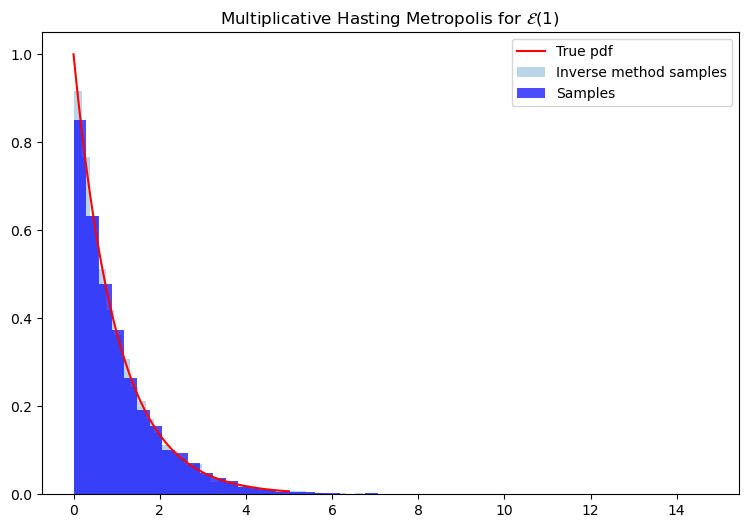

In [120]:

plt.figure(figsize=(9, 6))
plt.hist(inv_method_samples, density = True, bins = 50, label = "Inverse method samples", alpha = 0.3)
plt.hist(samples1, density = True, bins = 50, label = "Samples", color = 'b', alpha = 0.7)

plt.plot(np.linspace(0, 5, 100), target(np.linspace(0, 5, 100)), label = "True pdf", c = 'r')
plt.legend()
plt.title(r"Multiplicative Hasting Metropolis for $\mathcal{E}(1)$ ")
plt.show()

Both methods fare very well. To be noted however the huge runtime for multiplicative HM (that we could accelerate with Numpy vectorization, but still).

We transition to a more complicated distribution for which we do not have a trivial inverse for the cdf. Let the target density be a 1-D GMM :

\begin{align*}
\pi(x) = \frac{1}{2} [ \mathcal{N}(x ; -2, 1) + \mathcal{N}(x ; 5, 2)]
\end{align*}

where  $\mathcal{N}(x ; \mu, \sigma)$ is the corresponding normal pdf.

In [95]:
target2 = lambda x: 1/2 * (stats.norm.pdf(x, loc = -2, scale = 1) + stats.norm.pdf(x, loc = 5, scale = 2)) #A camel ! (1-D GMM)


NUM_SAMPLES = 10000 #Number of samples to draw, to plot the histogram
INIT = 1
HM_ITER = 20 #Number of iterations for the HM algorithm (length of the chain)


samples = []
for _ in tqdm(range(NUM_SAMPLES)):
    sample = multiplicativeHastingMetropolis(INIT, target2, maxIter = HM_ITER)
    samples.append(sample)




100%|██████████| 10000/10000 [00:43<00:00, 227.91it/s]


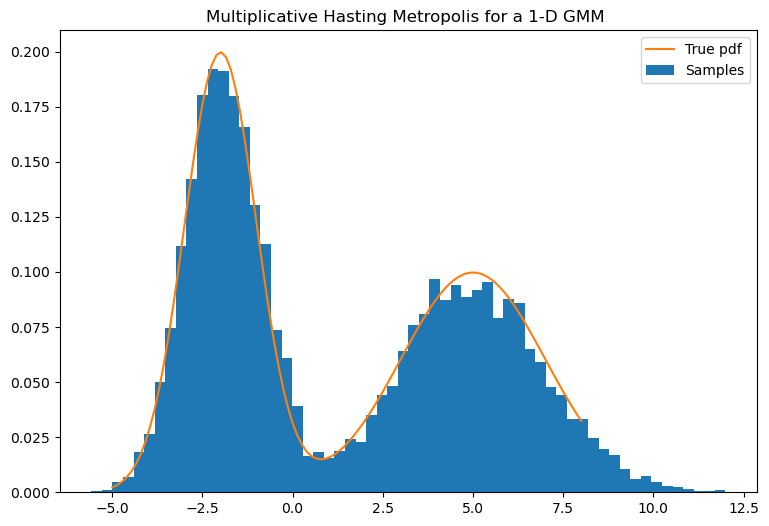

In [96]:
x = np.linspace(-5, 8, 100)
plt.figure(figsize=(9, 6))
plt.hist(samples, density = True, bins = 60, label = "Samples")
plt.plot(x, target2(x), label = "True pdf")
plt.legend()
plt.title(r"Multiplicative Hasting Metropolis for a 1-D GMM ")
plt.show()

It works well, and we just have to know the density function (up to a normalizing constant) !